In [9]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd

# Voltajes medidos (en mvoltios)
V_medidos = np.array([401.7,427.5,451.6,476.4,501.3,526,549.7,571.7,593.5,612,630,649,663,676,688,697,707,715,722,728,733,738,743,748,751])  
V1_medidos=np.array([401.8,427.1,451.0,475.2,499.4,522.6,544.4,564.2,582.9,599,613,627,638,649,657,666,673,679,686,691,696,700,704,708,711,715,718,722,724,727,731,772])[:-2]
# Germanio
V2_medidos=np.array([400.7,426.2,450.5,475.2,499.9,524.6,550,574.1,598.6,621,644,666,685,700,713,722,731,738,744,749,754])[:-1]
V3_medidos=np.array([400.6,426.1,450.4,475.2,499.9,524.7,549.9,574.3,599,622,646,672,694,715,735,748,761])
# Corrientes medidas (en mAmperios)
I_medidos = np.array([.01,.02,.02,.06,.1,.17,.29,.46,.73,1.09,1.58,2.3,3.11,4.11,5.21,6.46,7.8,9.26,10.90,12.55,14.51,15.92,17.67,19.40,21.22]) 
I3_medidos=np.array([0,0,0,0,0,0,0,0,0.01,0.02,0.06,0.13,0.29,0.61,1.15,1.94,3.01])
#Corrientes medidas en (microAmperios)
I1_medidos=np.array([3.6,7.1,13.2,24,42.4,114.4,173.9,256.5,357,483.9,645,817,1008,1212,1434,1671,1912,2187,2449,2720,2985,3260,3538,3830,4121,4416,4695,4980,5277,5862,35.15])[:-1]
I2_medidos=np.array([0,0,0.1,0.4,0.9,2,4.6,10.3,22.8,49.5,108.9,205,355.5,555.3,782,1041,1328,1640,1958,2303])

# Parámetros conocidos
q = 1.602e-19  # Carga del electrón en Coulombs
T = 25 + 273.15  # Temperatura en Kelvin (ejemplo: 25°C ambiente)
k_boltzmann = 1.38064852e-23  # Constante de Boltzmann en J/K
n = 2  # Coeficiente de idealidad para el silicio


V_medidos = V2_medidos*1e-3  # Convertir a voltios
I_medidos = I2_medidos*1e-6  # Convertir a Amperios

# Función de la ecuación del diodo ideal (sin el -1)
def ecuacion_diodo(V, I_s, b):
    return I_s * np.exp(b * V)

In [10]:
def ajuste_exponencial(V_medidos, I_medidos, ecuacion_diodo, q, n, k_boltzmann, T):
    """
    Realiza el ajuste exponencial de los datos V-I de un diodo y calcula los parámetros ajustados.
    
    Parámetros:
    - V_medidos: array de voltajes medidos (en Voltios).
    - I_medidos: array de corrientes medidas (en Amperios).
    - ecuacion_diodo: función que representa la ecuación del diodo.
    - q: carga del electrón (en Coulombs).
    - n: coeficiente de idealidad del diodo.
    - k_boltzmann: constante de Boltzmann (en J/K).
    - T: temperatura absoluta (en Kelvin).
    
    Retorna:
    - I_s_ajustado: corriente de saturación ajustada.
    - b_ajustado: parámetro b ajustado.
    - I_s_error: incerteza de I_s_ajustado.
    - b_error: incerteza de b_ajustado.
    - k_b_calculado: valor calculado de la constante de Boltzmann.
    - k_b_error: incerteza de k_b_calculado.
    - chi_cuadrado_reducido: valor del chi-cuadrado reducido.
    """
    # Ajuste exponencial directo
    popt_exp, pcov_exp = curve_fit(
        ecuacion_diodo, V_medidos, I_medidos, 
        p0=(1e-12, q / (n * k_boltzmann * T)), 
        maxfev=10000
    )

    # Parámetros ajustados
    I_s_ajustado = popt_exp[0]
    b_ajustado = popt_exp[1]

    # Incertezas de los parámetros ajustados
    I_s_error = np.sqrt(pcov_exp[0, 0])
    b_error = np.sqrt(pcov_exp[1, 1])

    # Cálculo de k_b a partir de b_ajustado
    k_b_calculado = q / (b_ajustado * n * T)
    k_b_error = (q / (n * T)) * (b_error / (b_ajustado**2))

    # Gráfica de los datos y el ajuste exponencial
    plt.figure(figsize=(8, 6))
    plt.scatter(V_medidos, I_medidos, label='Datos experimentales')
    V_fit = np.linspace(min(V_medidos), max(V_medidos), 1000)
    I_fit = ecuacion_diodo(V_fit, I_s_ajustado, b_ajustado)
    plt.plot(V_fit, I_fit, color='red', label='Ajuste exponencial')
    plt.xlabel('Voltaje (V)')
    plt.ylabel('Corriente (A)')
    plt.title('Curva V-I del Diodo y Ajuste Exponencial')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Cálculo del chi-cuadrado reducido
    # Crear una máscara para evitar valores de I_medidos iguales a cero o muy pequeños
    epsilon = 1e-15  # Valor pequeño para evitar divisiones por cero
    mask = I_medidos > epsilon

    # Aplicar la máscara
    residuos = I_medidos[mask] - ecuacion_diodo(V_medidos[mask], *popt_exp)
    chi_cuadrado = np.sum((residuos / I_medidos[mask])**2)


    print(f"I_s ajustado: {I_s_ajustado:.3e} ± {I_s_error:.3e} A")
    print(f"b ajustado: {b_ajustado:.3e} ± {b_error:.3e} V⁻¹")
    print(f"k_b calculado: {k_b_calculado:.3e} ± {k_b_error:.3e} J/K")
    print(f"Chi-cuadrado: {chi_cuadrado:.2f}")

    return I_s_ajustado, b_ajustado, I_s_error, b_error, k_b_calculado, k_b_error, chi_cuadrado


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ajuste_exponencial(V_medidos, I_medidos, ecuacion_diodo, q, n, k_boltzmann, T):
    """
    Realiza el ajuste exponencial de los datos V-I de un diodo y calcula los parámetros ajustados.
    
    Parámetros:
    - V_medidos: array de voltajes medidos (en Voltios).
    - I_medidos: array de corrientes medidas (en Amperios).
    - ecuacion_diodo: función que representa la ecuación del diodo.
    - q: carga del electrón (en Coulombs).
    - n: coeficiente de idealidad del diodo.
    - k_boltzmann: constante de Boltzmann (en J/K).
    - T: temperatura absoluta (en Kelvin).
    
    Retorna:
    - I_s_ajustado: corriente de saturación ajustada.
    - b_ajustado: parámetro b ajustado.
    - I_s_error: incerteza de I_s_ajustado.
    - b_error: incerteza de b_ajustado.
    - k_b_calculado: valor calculado de la constante de Boltzmann.
    - k_b_error: incerteza de k_b_calculado.
    - chi_cuadrado: valor del chi-cuadrado.
    """
    # Ajuste exponencial directo
    popt_exp, pcov_exp = curve_fit(
        ecuacion_diodo, V_medidos, I_medidos, 
        p0=(1e-12, q / (n * k_boltzmann * T)), 
        maxfev=10000
    )

    # Parámetros ajustados
    I_s_ajustado = popt_exp[0]
    b_ajustado = popt_exp[1]

    # Incertezas de los parámetros ajustados
    I_s_error = np.sqrt(pcov_exp[0, 0])
    b_error = np.sqrt(pcov_exp[1, 1])

    # Cálculo de k_b a partir de b_ajustado
    k_b_calculado = q / (b_ajustado * n * T)
    k_b_error = (q / (n * T)) * (b_error / (b_ajustado**2))

    # Valores ajustados usando la ecuación del diodo
    I_ajustados = ecuacion_diodo(V_medidos, I_s_ajustado, b_ajustado)

    # Gráfica de los datos y el ajuste exponencial
    plt.figure(figsize=(8, 6))
    plt.scatter(V_medidos, I_medidos, label='Datos experimentales')
    V_fit = np.linspace(min(V_medidos), max(V_medidos), 1000)
    I_fit = ecuacion_diodo(V_fit, I_s_ajustado, b_ajustado)
    plt.plot(V_fit, I_fit, color='red', label='Ajuste exponencial')
    plt.xlabel('Voltaje (V)')
    plt.ylabel('Corriente (A)')
    plt.title('Curva V-I del Diodo y Ajuste Exponencial')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Cálculo del chi-cuadrado utilizando histograms
    # Definir el número de intervalos usando el criterio de Sturges
    n_datos = len(I_medidos)
    nbin = int(1 + 3.322 * np.log10(n_datos))
    
    # Definir el rango común mínimo y máximo para los datos experimentales y ajustados
    ymin = min(min(I_medidos), min(I_ajustados))
    ymax = max(max(I_medidos), max(I_ajustados))
    
    # Crear los histogramas de los datos experimentales y ajustados
    plt.figure(dpi=150)
    counts_ajustados, bins_ajustados, _ = plt.hist(I_ajustados, bins=nbin, range=(ymin, ymax), alpha=0.5, label='Ajuste')
    counts_experimentales, bins_experimentales, _ = plt.hist(I_medidos, bins=nbin, range=(ymin, ymax), alpha=0.5, label='Datos Experimentales')
    plt.legend()
    plt.show()
    
    # Definir la función para calcular el chi-cuadrado
    def chi_sqr(dathistexp, dathistaj):
        # Evitar divisiones por cero
        mask = dathistaj > 0
        chi2 = np.sum(((dathistexp[mask] - dathistaj[mask])**2) / dathistaj[mask])
        return chi2

    # Calcular el chi-cuadrado
    chi_cuadrado = chi_sqr(counts_experimentales, counts_ajustados)
    grados_libertad = nbin - 1 - len(popt_exp)  # Restamos el número de parámetros ajustados
    chi_cuadrado = chi_cuadrado / grados_libertad

    print(f"I_s ajustado: {I_s_ajustado:.3e} ± {I_s_error:.3e} A")
    print(f"b ajustado: {b_ajustado:.3e} ± {b_error:.3e} V⁻¹")
    print(f"k_b calculado: {k_b_calculado:.3e} ± {k_b_error:.3e} J/K")
    print(f"Chi-cuadrado: {chi_cuadrado:.2f}")

    return I_s_ajustado, b_ajustado, I_s_error, b_error, k_b_calculado, k_b_error, chi_cuadrado


/tmp/ipykernel_10061/140242458.py:33: RuntimeWarning: overflow encountered in exp
  return I_s * np.exp(b * V)


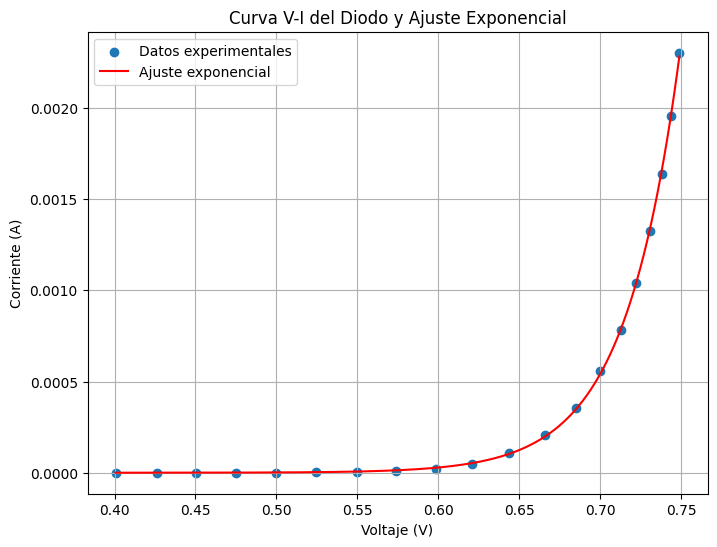

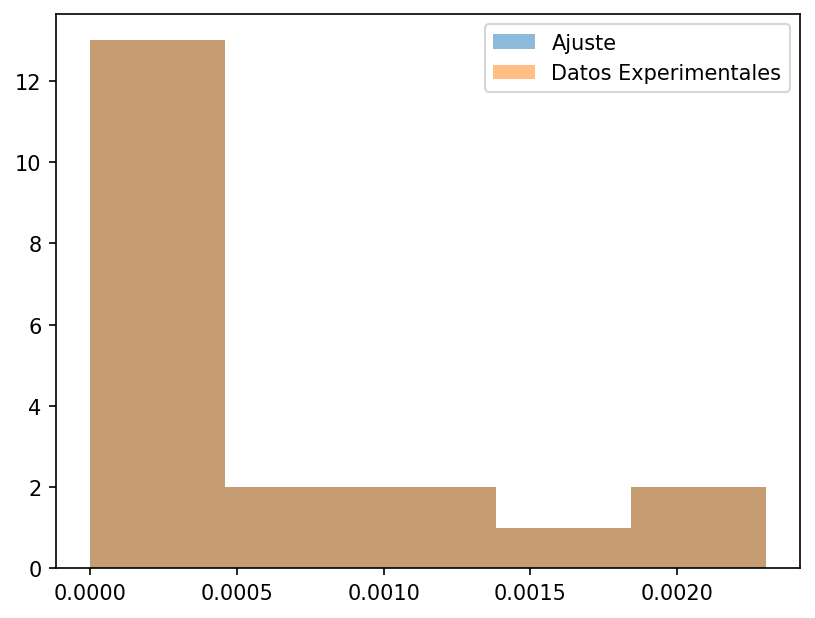

I_s ajustado: 6.154e-13 ± 8.248e-14 A
b ajustado: 2.942e+01 ± 1.814e-01 V⁻¹
k_b calculado: 9.132e-24 ± 5.631e-26 J/K
Chi-cuadrado: 0.00


In [12]:
# Llamar a la función
I_s_ajustado, b_ajustado, I_s_error, b_error, k_b_calculado, k_b_error, chi_cuadrado = ajuste_exponencial(V_medidos, I_medidos, ecuacion_diodo, q, n, k_boltzmann, T)

In [13]:
def ajuste_linealizacion(V_medidos, I_medidos, q, n, T, i_inicio=0, i_fin=None):
    """
    Realiza el análisis de linealización de los datos V-I de un diodo y calcula los parámetros ajustados.
    
    Parámetros:
    - V_medidos: array de voltajes medidos (en Voltios).
    - I_medidos: array de corrientes medidas (en Amperios).
    - q: carga del electrón (en Coulombs).
    - n: coeficiente de idealidad del diodo.
    - T: temperatura absoluta (en Kelvin).
    - i_inicio: índice de inicio de la región lineal.
    - i_fin: índice de fin de la región lineal.
    
    Retorna:
    - m_ajustado: pendiente ajustada.
    - c_ajustado: ordenada al origen ajustada.
    - m_error: incerteza de m_ajustado.
    - c_error: incerteza de c_ajustado.
    - k_b_calculado_lin: valor calculado de la constante de Boltzmann.
    - k_b_error_lin: incerteza de k_b_calculado_lin.
    - r_cuadrado: coeficiente de correlación R² del ajuste.
    """
    # Tomamos el logaritmo natural de la corriente
    ln_I = np.log(I_medidos)
    
    # Si i_fin no está definido, tomamos hasta el final del array
    if i_fin is None:
        i_fin = len(V_medidos)
    
    # Selección de la región lineal
    V_lineal = V_medidos[i_inicio:i_fin]
    ln_I_lineal = ln_I[i_inicio:i_fin]
    
    # Filtrar valores inf y NaN
    mask = np.isfinite(ln_I_lineal)
    V_lineal = V_lineal[mask]
    ln_I_lineal = ln_I_lineal[mask]
    
    # Definir la función lineal
    def ajuste_lineal(V, m, c):
        return m * V + c
    
    # Realizar el ajuste lineal
    popt_lin, pcov_lin = curve_fit(ajuste_lineal, V_lineal, ln_I_lineal)
    m_ajustado = popt_lin[0]
    c_ajustado = popt_lin[1]
    
    # Incertezas de los parámetros ajustados
    m_error = np.sqrt(pcov_lin[0, 0])
    c_error = np.sqrt(pcov_lin[1, 1])
    
    # Cálculo de k_b a partir de m_ajustado
    k_b_calculado_lin = q / (n * T * m_ajustado)
    k_b_error_lin = (q / (n * T)) * (m_error / (m_ajustado**2))
    
    # Gráfica del ajuste lineal
    plt.figure(figsize=(8, 6))
    plt.scatter(V_lineal, ln_I_lineal, label='Datos linealizados')
    V_fit_lin = np.linspace(min(V_lineal), max(V_lineal), 100)
    ln_I_fit_lin = ajuste_lineal(V_fit_lin, m_ajustado, c_ajustado)
    plt.plot(V_fit_lin, ln_I_fit_lin, color='green', label='Ajuste lineal')
    plt.xlabel('Voltaje (V)')
    plt.ylabel('ln(Corriente (A))')
    plt.title('Linealización de la Curva V-I del Diodo')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Cálculo del coeficiente de correlación R²
    residuos_lin = ln_I_lineal - ajuste_lineal(V_lineal, *popt_lin)
    ss_res = np.sum(residuos_lin**2)
    ss_tot = np.sum((ln_I_lineal - np.mean(ln_I_lineal))**2)
    r_cuadrado = 1 - (ss_res / ss_tot)
    
    print(f"Pendiente ajustada (m): {m_ajustado:.3e} ± {m_error:.3e} V⁻¹")
    print(f"Ordenada al origen (c): {c_ajustado:.3e} ± {c_error:.3e}")
    print(f"k_b calculado: {k_b_calculado_lin:.3e} ± {k_b_error_lin:.3e} J/K")
    print(f"Coeficiente de correlación R²: {r_cuadrado:.4f}")
    
    return m_ajustado, c_ajustado, m_error, c_error, k_b_calculado_lin, k_b_error_lin, r_cuadrado

/tmp/ipykernel_10061/303553585.py:24: RuntimeWarning: divide by zero encountered in log
  ln_I = np.log(I_medidos)


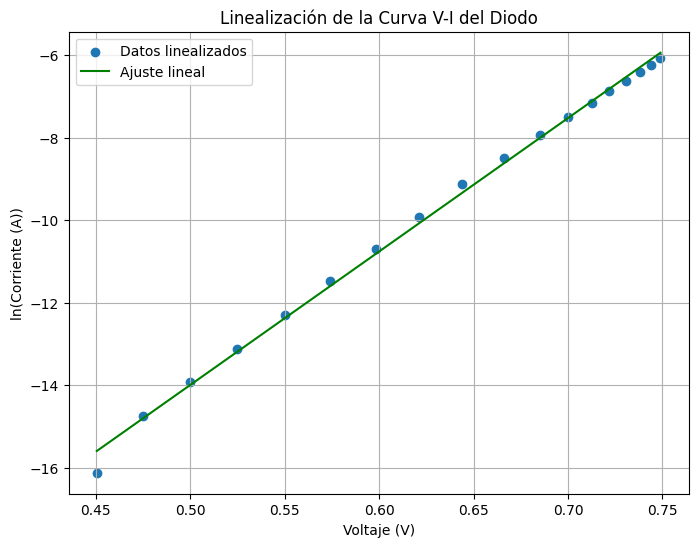

Pendiente ajustada (m): 3.233e+01 ± 4.237e-01 V⁻¹
Ordenada al origen (c): -3.016e+01 ± 2.711e-01
k_b calculado: 8.309e-24 ± 1.089e-25 J/K
Coeficiente de correlación R²: 0.9973


In [14]:
m_ajustado, c_ajustado, m_error, c_error, k_b_calculado_lin, k_b_error_lin, r_cuadrado = ajuste_linealizacion(
    V_medidos, I_medidos, q, n, T)

In [15]:
def mostrar_resultados(
    I_s_ajustado, I_s_error, b_ajustado, b_error, k_b_calculado, k_b_error,
    m_ajustado, m_error, c_ajustado, c_error, k_b_calculado_lin, k_b_error_lin,
    k_boltzmann
):
    """
    Muestra los resultados finales de los ajustes exponencial y lineal, incluyendo los errores porcentuales.

    Parámetros:
    - I_s_ajustado: corriente de saturación ajustada del ajuste exponencial.
    - I_s_error: incerteza de I_s_ajustado.
    - b_ajustado: parámetro b ajustado del ajuste exponencial.
    - b_error: incerteza de b_ajustado.
    - k_b_calculado: valor calculado de k_b a partir del ajuste exponencial.
    - k_b_error: incerteza de k_b_calculado.
    - m_ajustado: pendiente ajustada del ajuste lineal.
    - m_error: incerteza de m_ajustado.
    - c_ajustado: ordenada al origen ajustada del ajuste lineal.
    - c_error: incerteza de c_ajustado.
    - k_b_calculado_lin: valor calculado de k_b a partir del ajuste lineal.
    - k_b_error_lin: incerteza de k_b_calculado_lin.
    - k_boltzmann: valor teórico de la constante de Boltzmann.

    No retorna ningún valor; simplemente imprime los resultados.
    """
    # Resultados del ajuste exponencial
    print("Resultados del ajuste exponencial:")
    print(f"I_s ajustado: {I_s_ajustado:.3e} ± {I_s_error:.3e} A")
    print(f"b ajustado: {b_ajustado:.3e} ± {b_error:.3e} V⁻¹")
    print(f"k_b calculado: {k_b_calculado:.3e} ± {k_b_error:.3e} J/K")

    # Resultados del ajuste lineal
    print("\nResultados del ajuste lineal:")
    print(f"Pendiente ajustada (m): {m_ajustado:.3e} ± {m_error:.3e} V⁻¹")
    print(f"Ordenada al origen (c): {c_ajustado:.3e} ± {c_error:.3e}")
    print(f"k_b calculado (lineal): {k_b_calculado_lin:.3e} ± {k_b_error_lin:.3e} J/K")

    # Error porcentual respecto al valor teórico de k_b
    error_porcentual_exp = abs((k_b_calculado - k_boltzmann) / k_boltzmann) * 100
    error_porcentual_lin = abs((k_b_calculado_lin - k_boltzmann) / k_boltzmann) * 100

    print(f"\nError porcentual (ajuste exponencial): {error_porcentual_exp:.2f}%")
    print(f"Error porcentual (ajuste lineal): {error_porcentual_lin:.2f}%")


In [16]:
mostrar_resultados(
    I_s_ajustado, I_s_error, b_ajustado, b_error, k_b_calculado, k_b_error,
    m_ajustado, m_error, c_ajustado, c_error, k_b_calculado_lin, k_b_error_lin,
    k_boltzmann
)

Resultados del ajuste exponencial:
I_s ajustado: 6.154e-13 ± 8.248e-14 A
b ajustado: 2.942e+01 ± 1.814e-01 V⁻¹
k_b calculado: 9.132e-24 ± 5.631e-26 J/K

Resultados del ajuste lineal:
Pendiente ajustada (m): 3.233e+01 ± 4.237e-01 V⁻¹
Ordenada al origen (c): -3.016e+01 ± 2.711e-01
k_b calculado (lineal): 8.309e-24 ± 1.089e-25 J/K

Error porcentual (ajuste exponencial): 33.85%
Error porcentual (ajuste lineal): 39.82%
